# 学習済みの分散表現（英語モデル）の利用

大量の文書から分散表現 (word2vec) を作成するのは計算量が非常に多いため、一般的に作成済みの word2vec を用いられることが多い。

- 単語の類似度
- 類似単語の検索
- 単語の類推 (Word Analogy)
- 類似度の可視化
- 短い文の類似度

<a href='https://colab.research.google.com/drive/1X3XmmomQZrR-rPGbo_w6yydDbui86tzK'>Word2Vec Application Tutorial</a> をもとに作成

### ソフトウェアのインストール

3_text_en/3_2_vectorize_spacy.ipynb で英語モデルをダウンロードしていなければ、以下を実行：
```
python -m spacy download en_core_web_lg
```

以下のセルでエラーが出たら、ノートブックをリスタート

In [3]:
import spacy
import numpy as np
import seaborn as sns

# 別の英語モデルのダウンロード方法
# python -m spacy download en_core_web_lg がうまくいかない場合はコメントアウト
# spacy.cli.download("en_core_web_lg")

# 英語のモデルをロード
nlp = spacy.load('en_core_web_lg')

In [4]:
# cat の分散表現
cat = nlp.vocab['cat']
print('dimension:', len(cat.vector))
print(cat.vector)

dimension: 300
[-0.15067   -0.024468  -0.23368   -0.23378   -0.18382    0.32711
 -0.22084   -0.28777    0.12759    1.1656    -0.64163   -0.098455
 -0.62397    0.010431  -0.25653    0.31799    0.037779   1.1904
 -0.17714   -0.2595    -0.31461    0.038825  -0.15713   -0.13484
  0.36936   -0.30562   -0.40619   -0.38965    0.3686     0.013963
 -0.6895     0.004066  -0.1367     0.32564    0.24688   -0.14011
  0.53889   -0.80441   -0.1777    -0.12922    0.16303    0.14917
 -0.068429  -0.33922    0.18495   -0.082544  -0.46892    0.39581
 -0.13742   -0.35132    0.22223   -0.144     -0.048287   0.3379
 -0.31916    0.20526    0.098624  -0.23877    0.045338   0.43941
  0.030385  -0.013821  -0.093273  -0.18178    0.19438   -0.3782
  0.70144    0.16236    0.0059111  0.024898  -0.13613   -0.11425
 -0.31598   -0.14209    0.028194   0.5419    -0.42413   -0.599
  0.24976   -0.27003    0.14964    0.29287   -0.31281    0.16543
 -0.21045   -0.4408     1.2174     0.51236    0.56209    0.14131
  0.092514   

### 単語の類似度

- spaCyに組み込みの関数

In [5]:
# cat と dog の類似度
dog = nlp.vocab['dog']
cat.similarity(dog)

0.8016854524612427

In [6]:
# cat と human
cat.similarity(nlp.vocab['human'])

0.34036731719970703

In [7]:
# cat と mathematics
cat.similarity(nlp.vocab['mathematics'])

0.05801314860582352

### 類似度の計算内容の確認

- コサイン類似度（= 1 - コサイン距離）の関数を定義して比較

In [8]:
from scipy.spatial.distance import cosine

def similarity_cosine(w1, w2):
    return 1 - cosine(w1, w2)

In [9]:
# コサイン類似度の関数を用いて計算
similarity_cosine(cat.vector, dog.vector)

0.8016855120658875

### 類似単語の検索

allwords
- ベクトルに含まれている全ての単語（小文字のみ）

similar_words()
- allwords から類似度が大きい単語の上位をソートして取り出す関数を定義
- 計算量は多い
  - ベクトルに含まれている全ての単語との類似度を計算
  - 全ての単語の類似度をソート

In [10]:
# ベクトルに含まれている単語
allwords = [nlp.vocab[key] for key in nlp.vocab.vectors if nlp.vocab[key].is_lower]

# 類似単語の検索
def similar_words(word, n=10):
    word_lexeme = nlp.vocab[word]
    candidates = sorted(allwords, key=lambda w: word_lexeme.similarity(w), reverse=True)
    return [w.text for w in candidates[:n] if w != word_lexeme.lower_]

In [11]:
similar_words('cat')

['cats', 'kitten', 'dog', 'kitty', 'pet', 'puppy', 'kittens', 'feline', 'dogs']

In [12]:
similar_words('car')

['cars',
 'vehicle',
 'automobile',
 'truck',
 'auto',
 'driving',
 'vehicles',
 'dealership',
 'rental']

### 単語の類推 (Word Analogy)

similar_words_by_vec()
- 単語のベクトルを計算して得られた値とコサイン類似度が大きい（コサイン距離が近い）単語の上位をソートして取り出す関数を定義

In [13]:
# ベクトルから類似単語の検索
def similar_words_by_vec(vector, exclude_list=[], n=15):
    candidates = sorted(allwords, key=lambda w: similarity_cosine(vector, w.vector),
                        reverse=True)
    return [w.text for w in candidates[:n] if w not in exclude_list]

単語のベクトルを加減することによる類推

In [14]:
# man にとっての king は、woman にとっては何か？
king = nlp.vocab['king']
man = nlp.vocab['man']
woman = nlp.vocab['woman']

# 類推したベクトル
analogy = king.vector - man.vector + woman.vector

# 上記の類推結果と queen との類似度
queen = nlp.vocab['queen']
similarity_cosine(analogy, queen.vector)

0.7880843877792358

In [15]:
# 類推結果に類似する単語
similar_words_by_vec(analogy, ['king', 'kings', 'man', 'woman'])

['queen',
 'prince',
 'princess',
 'royal',
 'throne',
 'queens',
 'monarch',
 'kingdom',
 'empress',
 'lady',
 'princes',
 'mother']

In [16]:
# walk にとっての run は、swim にとっては何か？
w1 = nlp.vocab['run']
w2 = nlp.vocab['walk']
w3 = nlp.vocab['swim']

# 類推したベクトル
analogy = w1.vector - w2.vector + w3.vector

# 類推結果に類似する単語
similar_words_by_vec(analogy, ['run', 'walk', 'swim'])

['swimmers',
 'running',
 'swims',
 'swimming',
 'swam',
 'swimmer',
 'ran',
 'triathlon',
 'diving',
 'dive',
 'varsity',
 'volleyball',
 'swimsuit']

### 類似度の可視化

spacy のベクトルは300次元のため、可視化には次元圧縮する必要がある。平面上にプロットできるように2次元に圧縮する。

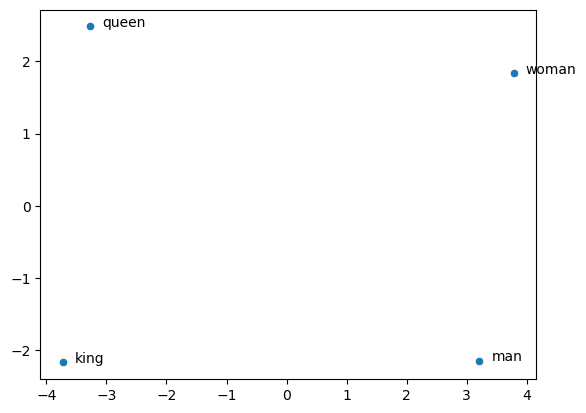

In [17]:
from sklearn.decomposition import PCA

def plot2d(labels):
    # ラベルのベクトル化
    data = np.array(list(map(lambda x: nlp.vocab[x].vector, labels)))

    # 2次元に圧縮
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)

    # 散布図
    ax = sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1])
    # 各点にラベルを付ける
    for i in range(len(data_2d)):
        crd = data_2d[i]
        ax.text(crd[0] + 0.2, crd[1], labels[i])

plot2d(['king', 'man', 'queen', 'woman'])

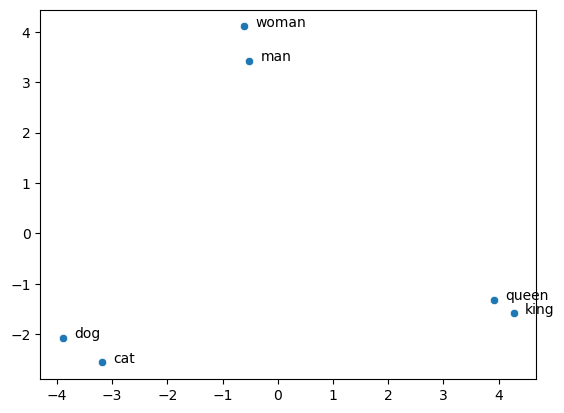

In [18]:
plot2d(['king', 'man', 'queen', 'woman', 'cat', 'dog'])

### 短い文の類似度

- 文の各単語ベクトルの平均値の類似度。
- 長文になると値が平均化して、類似度が高くなりやすい。

In [19]:
s1 = nlp('King is a man.')
s2 = nlp('Queen is a woman.')
s1.similarity(s2)

0.9056070520420546

In [20]:
s3 = nlp('A black cat crosses your path.')
s1.similarity(s3)

0.7574695817284507